# RO47002 Machine Learning for Robotics
* (c) TU Delft, 2024
* Period: 2024-2025, Q1
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682421

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [240]:
GROUP_NUMBER = "31"
STUDENT_NAME1 = "Marcel Riedeman"
STUDENT_NUMBER1 = "5314429"
STUDENT_NAME2 = "Harsh Bhatia"
STUDENT_NUMBER2 = "6315658"

In [241]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert(GROUP_NUMBER != "")
assert(STUDENT_NAME1 != "")
assert(STUDENT_NUMBER1 != "")
assert(STUDENT_NAME2 != "")
assert(STUDENT_NUMBER2 != "")

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you and your lab partner alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled practicum hours to ask a TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---

# Practicum 4

* Topic:  SVMs, Decision trees, Ensemble Methods, imitation learning
* Before performing this practicum, work through **Book chapter(s): 5, 6, 7**
* **Deadline**: Monday, September 30, 2024, 23:59

## Objectives

### Part 1 - SVMs, Decision trees, Ensemble methods
* Discover a data set and prepare it for algorithms
* Use SKLearn libraries to implement classifiers
* Inspect a decision tree
* Explore how bagging improves a very simple classifier

### Part 2 - Implementations
* Re-implement a linear SVM
* Re-implement a voting classifier

### Part 3 - Imitation Learning and Motion Planning
* Build a dataset using an oracle
* Use a classifier to imitate the behavior of a motion planning algorithm
* Explore how the construction of the dataset can affect the performance of the classifier


### Setup common python stuff
We will start by loading a few common python dependencies

In [242]:
# Python =3.10 is required
import sys
assert sys.version_info[:2] == (3, 10)

# Scikit-Learn 1.1 is required
import sklearn
assert (sklearn.__version__ >= "1.1" and sklearn.__version__ <= "1.3.2")

# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets

In [243]:
def plot_feature_space_function(f, X, y, axes, class_1=0, class_2=1, res=0.1):
    """ 
    Plot the 2D feature space of the first two features of the data in X.
    For the feature space, plot the samples in X with their class labels y,
    and also overlay a countour plot with the function f(x) evaluated at a grid within
    the shown region of the feature space (the size of the region is determined by the extent of the data).
    based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    """
    
    if f is not None:
        xx, yy = np.meshgrid(np.arange(axes[0], axes[1], res),np.arange(axes[2], axes[3], res))

        Z = f(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.4)
        
    plt.plot(X[y==class_1,0], X[y==class_1,1], '.', label='class '+str(class_1), zorder=-1)
    plt.plot(X[y==class_2,0], X[y==class_2,1], '.', label='class '+str(class_2), zorder=-1)
    plt.grid('on')
    plt.axis(axes)
    plt.legend()

In [244]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def print_accuracy_confusion(y_test, y_pred, clf_name=''):
    print(clf_name, 'accuracy score:', accuracy_score(y_test, y_pred))
    print(clf_name, 'confusion matrix:\n', confusion_matrix(y_test, y_pred))

## 1) Exploring and preparing a dataset
We are going to use a dataset for classifying hand gestures from EMG signals for the first part of this practicum. The description and original source can be found here: https://www.kaggle.com/kyr7plus/emg-4

This kind of data cannot only be used for controlling prosthetics, but also for other human-robot interaction applications. Here is a little example from another CoR staff member, Luka Peternel, on the use of EMG sensors in human-robot interaction https://youtu.be/eXspt7_KY8c?t=156

Your first task is to read the description on the website and to figure out how the dataset is structured.
Load the correct file (included in folder `hand_gestures` in this practicum) for each variable `df_rock`, `df_paper`, `df_scissors`, and `df_ok` using 

In [245]:
import pandas as pd

# Load each gesture's data
df_rock = pd.read_csv('./hand_gestures/0.csv', header=None)
df_scissors = pd.read_csv('./hand_gestures/1.csv', header=None)
df_paper = pd.read_csv('./hand_gestures/2.csv', header=None)
df_ok = pd.read_csv('./hand_gestures/3.csv', header=None)

# Combine all gesture DataFrames
df = pd.concat([df_rock, df_scissors, df_paper, df_ok], ignore_index=True)


In [246]:
assert df.shape[0] == 11678
assert df.shape[1] == 65

**1.01)** Now convert the pandas dataframe to numpy matrices `X_4class` and `y_4class` for the features and labels respectively.

In [247]:
# 1.01) Convert the pandas dataframe to numpy matrices X_4class and y_4class
# hint: use df.iloc.values or np.array(df)

# YOUR CODE HERE
import numpy as np

# Convert the DataFrame to numpy arrays
X_4class = df.iloc[:, :-1].values  # All columns except the last one (features)
y_4class = df.iloc[:, -1].values   # The last column (labels)


In [248]:
assert X_4class.shape[0] == 11678
assert y_4class.shape[0] == 11678
assert y_4class.ndim == 1
assert isinstance(X_4class, np.ndarray)
assert isinstance(y_4class, np.ndarray)

In [249]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/4class.npz')
# X_4class = npzfile['X_4class']
# y_4class = npzfile['y_4class']

<div class="alert alert-info">
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726377/View">Lecture 4A - SVMs (intuition)</a></h3>
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726379/View">Lecture 4B - SVMs (formalized)</a></h3>
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726381/View">Lecture 4C - SVMs (hyperparameter C)</a></h3>
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726425/View">Lecture 4E - Decision Trees</a></h3>
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726427/View">Lecture 4F - Ensemble Methods</a></h3>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

**1.02)** Let's use classifiers in the SKLearn library to create an SGD, a SVM, a DT, and a RF with the following parameters:
- `random_state=0`
- SGD should use the log loss.
- The SVM must have HARD margings, set the parameter `svm_C` accordingly.
- The DT must have at maximum 3 levels.

In [250]:
# 1.02) Adjusted code to prevent long execution times

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time

# Splitting the dataset
X_4class_train, X_4class_test, y_4class_train, y_4class_test = train_test_split(
    X_4class, y_4class, test_size=0.25, random_state=0)

# Feature Scaling
sc_4class = StandardScaler()
X_4class_train = sc_4class.fit_transform(X_4class_train)
X_4class_test = sc_4class.transform(X_4class_test)

# Define classifiers with adjusted parameters
random_state = 0
sgd_loss = 'log_loss'     # Corrected loss function
svm_C = 1.0               # Reduced C value
dt_max_depth = 3          # Maximum depth for Decision Tree

# Defining classifiers
sgd_clf_4class = SGDClassifier(
    loss=sgd_loss, max_iter=1000, tol=1e-3, random_state=random_state)
svm_clf_4class = SVC(
    C=svm_C, kernel='linear', random_state=random_state)
dt_clf_4class = DecisionTreeClassifier(
    max_depth=dt_max_depth, random_state=random_state)
rf_clf_4class = RandomForestClassifier(
    n_estimators=50, max_depth=5, random_state=random_state)

# Timing and fitting classifiers
# SGD Classifier
start_time = time.time()
sgd_clf_4class.fit(X_4class_train, y_4class_train)
sgd_fit_time = time.time() - start_time
print(f"SGD Classifier fit time: {sgd_fit_time:.2f} seconds")

# SVM Classifier
start_time = time.time()
svm_clf_4class.fit(X_4class_train, y_4class_train)
svm_fit_time = time.time() - start_time
print(f"SVM Classifier fit time: {svm_fit_time:.2f} seconds")

# Decision Tree Classifier
start_time = time.time()
dt_clf_4class.fit(X_4class_train, y_4class_train)
dt_fit_time = time.time() - start_time
print(f"Decision Tree Classifier fit time: {dt_fit_time:.2f} seconds")

# Random Forest Classifier
start_time = time.time()
rf_clf_4class.fit(X_4class_train, y_4class_train)
rf_fit_time = time.time() - start_time
print(f"Random Forest Classifier fit time: {rf_fit_time:.2f} seconds")

# Predicting Test set results
sgd_y_4class_pred = sgd_clf_4class.predict(X_4class_test)
svm_y_4class_pred = svm_clf_4class.predict(X_4class_test)
dt_y_4class_pred = dt_clf_4class.predict(X_4class_test)
rf_y_4class_pred = rf_clf_4class.predict(X_4class_test)

# Evaluating the classifiers
print_accuracy_confusion(y_4class_test, sgd_y_4class_pred, clf_name='SGD Classifier')
print_accuracy_confusion(y_4class_test, svm_y_4class_pred, clf_name='SVM Classifier')
print_accuracy_confusion(y_4class_test, dt_y_4class_pred, clf_name='Decision Tree Classifier')
print_accuracy_confusion(y_4class_test, rf_y_4class_pred, clf_name='Random Forest Classifier')


SGD Classifier fit time: 0.48 seconds
SVM Classifier fit time: 9.24 seconds
Decision Tree Classifier fit time: 0.05 seconds
Random Forest Classifier fit time: 0.40 seconds
SGD Classifier accuracy score: 0.3071917808219178
SGD Classifier confusion matrix:
 [[290 112 159 145]
 [147 182 159 221]
 [173 153 205 215]
 [197 160 182 220]]
SVM Classifier accuracy score: 0.34828767123287674
SVM Classifier confusion matrix:
 [[199 177 162 168]
 [  0 399 205 105]
 [ 19 303 229 195]
 [  5 335 229 190]]
Decision Tree Classifier accuracy score: 0.47191780821917806
Decision Tree Classifier confusion matrix:
 [[452 222  31   1]
 [  0 687  22   0]
 [ 23 490 230   3]
 [ 38 694  18   9]]
Random Forest Classifier accuracy score: 0.751027397260274
Random Forest Classifier confusion matrix:
 [[676   5  10  15]
 [  0 657  50   2]
 [ 16  46 675   9]
 [ 78 445  51 185]]


In [251]:
# Please note: The expected outcome for the worst classifier should be better than 30%, and the others will perform even better.
assert accuracy_score(y_4class_test, sgd_y_4class_pred) > 0.3
assert accuracy_score(y_4class_test, svm_y_4class_pred) > 0.3
assert accuracy_score(y_4class_test, dt_y_4class_pred) > 0.3
assert accuracy_score(y_4class_test, rf_y_4class_pred) > 0.3


**1.03)** You might have noticed that both SGD and DT have a poor accuracy score. Instead of tuning the hyper-parameters, we will work the data to show its influence on the methods.

For that, we will consider only 2 out of the 4 classes in this dataset which are easiest to distinguish, so we can focus on binary classifiers.
Based on the confusion matrix above, which classes are easiest to distinguish?

In [252]:
# Set the correct value. Ensure that class_1 < class_2.
class_1 = 0
class_2 = 1


In [253]:
assert class_1 is not None
assert class_2 is not None


**1.04)** Now we create 2 new variables `X_binary` and `y_binary` that only contain these 2 classes (the easiest to distinguish). Hint: use Boolean indexing and bitwise logic operators.

In [254]:

import numpy as np

# Create a boolean mask for the selected classes
mask = (y_4class == class_1) | (y_4class == class_2)

# Apply the mask to the features and labels
X_binary = X_4class[mask]
y_binary = y_4class[mask]

# Convert the labels to binary
y_binary = np.where(y_binary == class_1, 0, 1)

# Verify the shapes
print("X_binary shape:", X_binary.shape)
print("y_binary shape:", y_binary.shape)
print("Unique classes in y_binary:", np.unique(y_binary))


X_binary shape: (5813, 64)
y_binary shape: (5813,)
Unique classes in y_binary: [0 1]


In [255]:
assert X_binary.shape[0] == 5813
assert X_binary.shape[1] == 64
assert y_binary.ndim == 1
assert X_binary[0,0] == 26.0
assert X_binary[5812,0] == -16.0

In [256]:
#If you are stuck here, uncomment the lines below to load variables

#npzfile = np.load('./get_unstuck/binary.npz')
#X_binary = npzfile['X_binary']
#y_binary = npzfile['y_binary']

Preparing the modified dataset...

In [257]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary, test_size=0.25, random_state=0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_binary = StandardScaler()
X_binary_train = sc_binary.fit_transform(X_binary_train)
X_binary_test = sc_binary.transform(X_binary_test)

**1.05)** Now let's create classifiers to see how they perform on the new data (the parameters not defined here must be set to default).
- `random_state = 0`
- a SVM classifier `svm_clf_binary`, with `C=100`
- a SGD classifier `sgd_clf_binary`, with log loss
- a decision tree classifier `dt_clf_binary`
- a random forest classifier `rf_clf_binary`

define them, fit them, and predict the values for the test set (use the variable names in the stub that displays the results)

In [258]:
# Defining and fitting multiple classifiers

# Setting the random state
random_state = 0

# Importing necessary classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Defining the classifiers with specified parameters
sgd_clf_binary = SGDClassifier(loss='log_loss', random_state=random_state)
svm_clf_binary = SVC(C=100, random_state=random_state)
dt_clf_binary = DecisionTreeClassifier(random_state=random_state)
rf_clf_binary = RandomForestClassifier(random_state=random_state)

# Fitting the classifiers to the training data
sgd_clf_binary.fit(X_binary_train, y_binary_train)
svm_clf_binary.fit(X_binary_train, y_binary_train)
dt_clf_binary.fit(X_binary_train, y_binary_train)
rf_clf_binary.fit(X_binary_train, y_binary_train)

# Predicting the test set results
sgd_y_binary_pred = sgd_clf_binary.predict(X_binary_test)
svm_y_binary_pred = svm_clf_binary.predict(X_binary_test)
dt_y_binary_pred = dt_clf_binary.predict(X_binary_test)
rf_y_binary_pred = rf_clf_binary.predict(X_binary_test)

# Printing results
print_accuracy_confusion(y_binary_test, sgd_y_binary_pred, 'sgd')
print_accuracy_confusion(y_binary_test, svm_y_binary_pred, 'svm')
print_accuracy_confusion(y_binary_test, dt_y_binary_pred, 'dt')
print_accuracy_confusion(y_binary_test, rf_y_binary_pred, 'rf')


sgd accuracy score: 0.5845942228335625
sgd confusion matrix:
 [[317 411]
 [193 533]]
svm accuracy score: 0.9903713892709766
svm confusion matrix:
 [[719   9]
 [  5 721]]
dt accuracy score: 0.9773039889958735
dt confusion matrix:
 [[707  21]
 [ 12 714]]
rf accuracy score: 0.9917469050894085
rf confusion matrix:
 [[726   2]
 [ 10 716]]


In [259]:
# Please note: The expected outcome for the worst classifier should be better than 50%, and the others will perform even better.
assert accuracy_score(y_binary_test, sgd_y_binary_pred) > 0.5
assert accuracy_score(y_binary_test, svm_y_binary_pred) > 0.5
assert accuracy_score(y_binary_test, dt_y_binary_pred) > 0.5
assert accuracy_score(y_binary_test, rf_y_binary_pred) > 0.5


Note how the accuracy score of the DT has increased. Remember from the class, DTs are strongly impacted by the data!

**1.06)** The dataset has 64 features, which are virtually impossible to visualize in 2D. The next steps are going to take us from those 64 features down to 2 features.

Take a look again at the description of the data set. Each sample contains measurements from 8 sensors, over 8 consecutive time steps. The measurements are very noisy anyhow, so average over the 8 time steps and create a new variable `X_binary_avg`. That can be done in 2 lines with numpy functions.

In [260]:
# Averaging over the 8 time steps to create X_binary_avg

# Reshaping X_binary to separate the 8 time steps and 8 sensors
X_binary_reshaped = X_binary.reshape(-1, 8, 8)

# Computing the average over the 8 time steps
X_binary_avg = X_binary_reshaped.mean(axis=1)


In [261]:
assert X_binary_avg.shape[0] == 5813
assert X_binary_avg.shape[1] == 8
assert X_binary_avg[0,0] == 8
assert X_binary_avg[5812,0] == 1.375

In [262]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/binary_avg.npz')
# X_binary_avg= npzfile['X_binary_avg']

**1.07)** Explore manually the dataset to see which features clearly distinguish the 2 classes (although it is not be possible to completely eliminate the overlap between classes). The function below can help with that.

In [263]:
def plot_data(X, y, feat_1, feat_2, class_1=0, class_2=1):
    plt.plot(X[y==class_1,feat_1], X[y==class_1,feat_2], '.', label='class '+str(class_1))
    plt.plot(X[y==class_2,feat_1], X[y==class_2,feat_2], '.', label='class '+str(class_2))
    plt.grid('on')
    plt.axis('equal')
    plt.xlabel('feature ' + str(feat_1))
    plt.ylabel('feature ' + str(feat_2))
    plt.legend()

Feature differences between classes:
Feature 0: 0.156082373608058
Feature 1: 0.00872158852141347
Feature 2: 0.003636080343476844
Feature 3: 0.008814320533444997
Feature 4: 0.07900357551673645
Feature 5: 0.03778399641087013
Feature 6: 2.7785201468323444
Feature 7: 0.13713169099864697


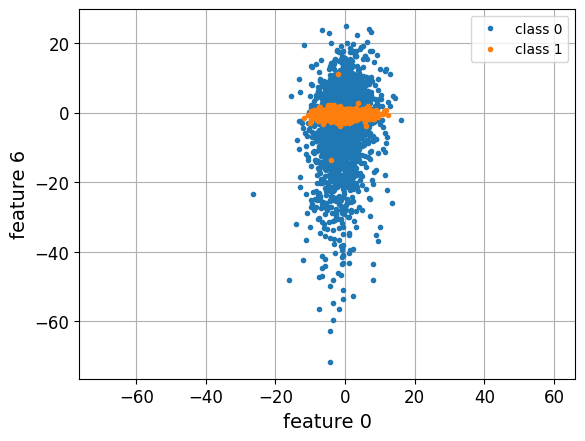

In [264]:
# Exploring the dataset to find features that distinguish the two classes
import numpy as np
import matplotlib.pyplot as plt

# Calculating the mean of each feature for each class
mean_class0 = X_binary_avg[y_binary == 0].mean(axis=0)
mean_class1 = X_binary_avg[y_binary == 1].mean(axis=0)

# Computing the absolute differences between class means for each feature
feature_differences = np.abs(mean_class0 - mean_class1)

# Printing the differences to identify the most distinguishing features
print("Feature differences between classes:")
for i, diff in enumerate(feature_differences):
    print(f"Feature {i}: {diff}")

# Selecting the two features with the largest differences
# For example, let's assume features 0 and 6 have the largest differences
feat_1 = 0
feat_2 = 6

# Plotting the data using the selected features
plot_data(X_binary_avg, y_binary, feat_1, feat_2)
plt.show()


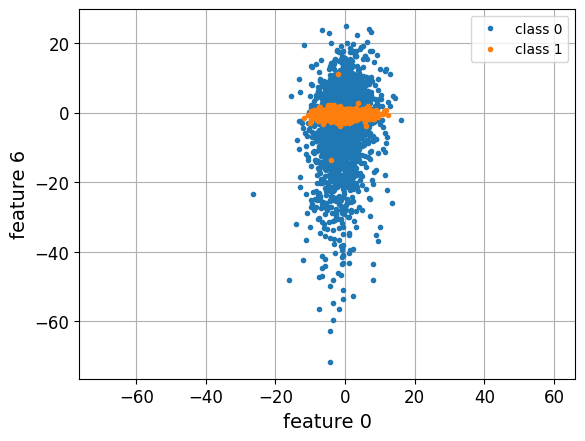

In [265]:
# Setting the features based on the largest differences
feat_1 = 0  # Feature with the second largest difference
feat_2 = 6  # Feature with the largest difference

# Plotting the data using the selected features
plot_data(X_binary_avg, y_binary, feat_1, feat_2)
plt.show()


In [266]:
assert feat_1 is not None
assert feat_2 is not None


**1.08)** Instead of checking the feature spaces manually (which is not always possible), we can also use an auto-generated decision tree to help us decide on the most informative features.

In [267]:
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(X_binary_avg, y_binary, test_size=0.25, random_state=0)

from sklearn.tree import DecisionTreeClassifier
dt_clf_simple = DecisionTreeClassifier(random_state=0, max_depth=3)
dt_clf_simple.fit(X_simple_train, y_simple_train)
dt_y_simple_pred = dt_clf_simple.predict(X_simple_test)

print_accuracy_confusion(y_simple_test, dt_y_simple_pred, 'dt_simple')

dt_simple accuracy score: 0.9044016506189821
dt_simple confusion matrix:
 [[615 113]
 [ 26 700]]


In [268]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(dt_clf_simple, out_file=None, filled=True, rounded=True, class_names=['0', '1'])  
graph = graphviz.Source(dot_data) 
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

Hopefully you'll come to a similar conclusion than with manual inspection.

In [269]:
# Add the correct values here. Ensure that feat_1 < feat_2.
feat_1 = 3
feat_2 = 6


In [270]:
assert feat_1 is not None
assert feat_2 is not None


**1.09)** One of the features is clearly dominant. Which other feature to use is a bit less clear cut. In any case, to select the other one, use the one with the lower feature index. We are next going to look at SVMs. Those work best with small to medium data sets.

Create a new subset of the averaged data (`X_binary_subset` and `y_binary_subset`) containing only the 2 features you chose and only every 3rd sample.

In [271]:
# Creating a new subset of the averaged data with the selected features and every 3rd sample
# Assuming feat_1 = 3 and feat_2 = 6 from previous steps

# Selecting the two chosen features
X_binary_selected_features = X_binary_avg[:, [feat_1, feat_2]]

# Selecting every 3rd sample from the data
X_binary_subset = X_binary_selected_features[::3]
y_binary_subset = y_binary[::3]


In [272]:
assert X_binary_subset.shape[0] == 1938
assert y_binary_subset.shape[0] == 1938
assert X_binary_subset.shape[1] == 2
assert X_binary_subset[0,0] == 0.5
assert X_binary_subset[1937,0] == -0.375
assert y_binary_subset[1937] == 1

In [273]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/binary_subset.npz')
# X_binary_subset = npzfile['X_binary_subset']
# y_binary_subset = npzfile['y_binary_subset']

Again some setup of the data etc.

In [274]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_binary_subset, y_binary_subset, test_size=0.25, random_state=0)

axes_subset = np.array([X_binary_subset[:, 0].min() - 1, X_binary_subset[:, 0].max() + 1, X_binary_subset[:, 1].min() - 1, X_binary_subset[:, 1].max() + 1])


**1.10)** Here is a random forest classifier to see how well we can still perform on this very reduced dataset.

rf accuracy score: 0.9010309278350516
rf confusion matrix:
 [[221  26]
 [ 22 216]]


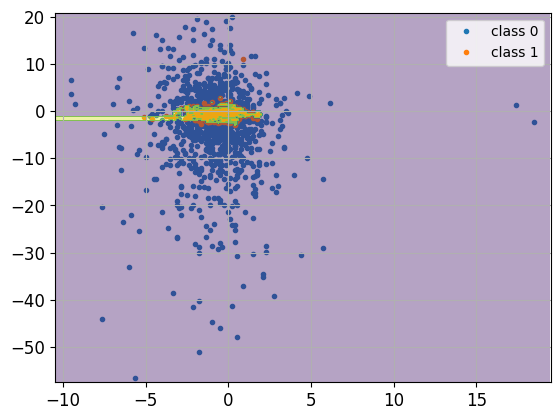

In [275]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(
    X_binary_subset, y_binary_subset, test_size=0.25, random_state=0)

# Defining the axes for plotting
axes_subset = np.array([
    X_binary_subset[:, 0].min() - 1, X_binary_subset[:, 0].max() + 1,
    X_binary_subset[:, 1].min() - 1, X_binary_subset[:, 1].max() + 1
])

# Defining and fitting the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf_subset = RandomForestClassifier(random_state=0)
rf_clf_subset.fit(X_subset_train, y_subset_train)

# Predicting the Test set results
rf_y_subset_pred = rf_clf_subset.predict(X_subset_test)

# Evaluating the classifier
print_accuracy_confusion(y_subset_test, rf_y_subset_pred, 'rf')

# Plotting the decision boundary and data points
plot_feature_space_function(rf_clf_subset.predict, X_binary_subset, y_binary_subset, axes_subset)
plt.show()


**1.11)** We can still do surprisingly well compared to the full dataset, even though we have drastically reduced the number of features.

Now create an non-linear SVM classifier `svm_clf_subset` that beats the random forest classifier in terms of accuracy.

svm accuracy score: 0.9195876288659793
svm confusion matrix:
 [[211  36]
 [  3 235]]


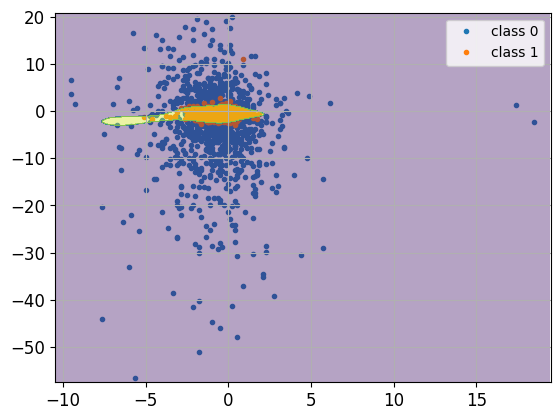

In [276]:
# Defining and fitting the non-linear SVM classifier
from sklearn.svm import SVC

# Setting up the SVM classifier with an RBF kernel and tuned hyperparameters
svm_clf_subset = SVC(kernel='rbf', C=100, gamma=0.1, random_state=0)
svm_clf_subset.fit(X_subset_train, y_subset_train)

# Predicting the Test set results
svm_y_subset_pred = svm_clf_subset.predict(X_subset_test)

# Evaluating the classifier
print_accuracy_confusion(y_subset_test, svm_y_subset_pred, 'svm')

# Plotting the decision boundary and data points
plot_feature_space_function(svm_clf_subset.predict, X_binary_subset, y_binary_subset, axes_subset)
plt.show()


In [277]:
assert accuracy_score(y_subset_test, svm_y_subset_pred) > 0.90103

# 2) Implementations

In this part, we are going to implement a linear SVM using the dual formulation. 


## 2.1) SVM
We will train the `sklearn` version of an SVM first, so we know what to expect from our own implementation. Check the Dual Formulation section in the book.

<div class="alert alert-info">
    <h3>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726423/View">Lecture 4D - SVMs - Dual problem and Kernel Trick</a></h3>
    The following part requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

**TIP:** being familiar with numpy arrays (see practicum 1) is also useful in this part.

As the data above can clearly not be separated by a linear decision boundary, we'll transform it once more. This obviously does not remove the overlap of the classes.

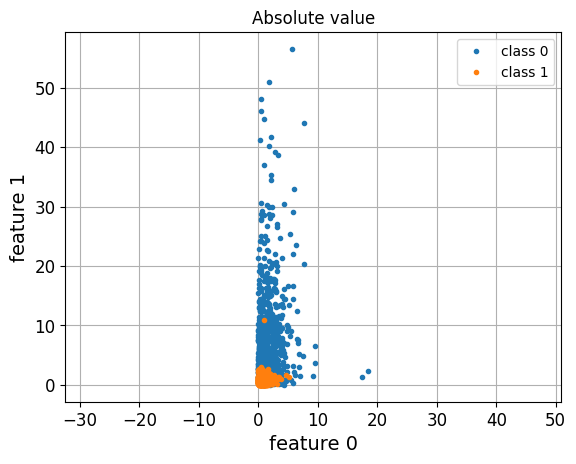

In [278]:
X_lin = np.abs(X_binary_subset)

plot_data(np.abs(X_lin), y_binary_subset, 0, 1, 0, 1)
plt.title('Absolute value')

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_binary_subset, test_size = 0.25, random_state = 0)

axes = np.array([X_lin[:, 0].min() - 1, X_lin[:, 0].max() + 1, X_lin[:, 1].min() - 1, X_lin[:, 1].max() + 1])

**2.1.01)** Before testing SVMs, let's see how well linear classifiers do now...

sgd accuracy score: 0.845360824742268
sgd confusion matrix:
 [[228  19]
 [ 56 182]]


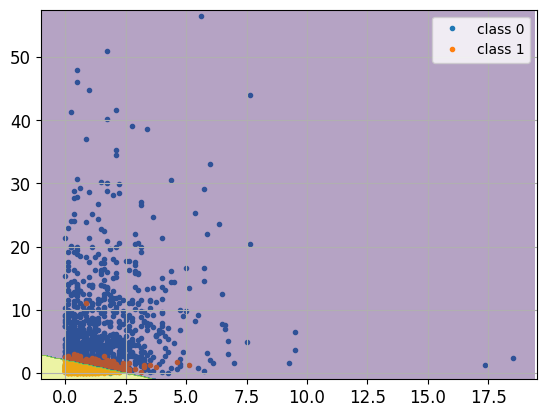

In [279]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train);
sgd_y_pred = sgd_clf.predict(X_test)
print_accuracy_confusion(y_test, sgd_y_pred, 'sgd')
plot_feature_space_function(sgd_clf.predict, X_lin, y_binary_subset, axes, 0 ,1)

Actually a lot better than on the initial dataset...

**2.1.02)** Now, before implementing an SVM, let's test with an sklearn linear SVM (using a linear kernel achieves the same as using LinearSVC, but this way of doing it gives us access to the support vectors). We'll compare our own implementation to this one later on.

lin_svm accuracy score: 0.8907216494845361
lin_svm confusion matrix:
 [[202  45]
 [  8 230]]


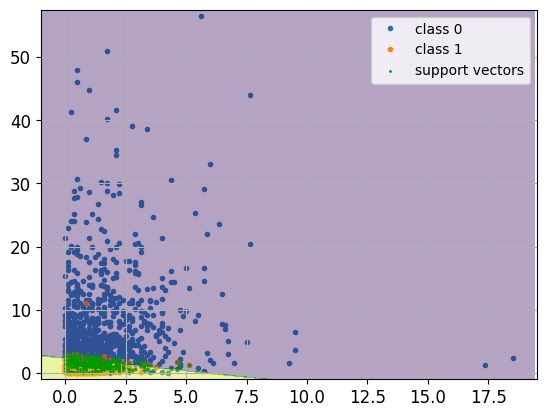

In [280]:
from sklearn.svm import SVC
lin_svm_clf = SVC(kernel="linear", C=2)
lin_svm_clf.fit(X_train, y_train)
lin_svm_y_pred = lin_svm_clf.predict(X_test)

print_accuracy_confusion(y_test, lin_svm_y_pred, 'lin_svm')
plot_feature_space_function(lin_svm_clf.predict, X_lin, y_binary_subset, axes, 0, 1)
svs = lin_svm_clf.support_vectors_
plt.scatter(svs[:, 0], svs[:, 1], s=1, facecolors='#009900', label='support vectors')
plt.legend()

**2.1.03)** Is the data linearly separable?
Do we hence use a hard margin or a soft margin SVM?

In [281]:
linearly_separable = 'no'

SVM_margin = 'soft'


In [282]:
assert 'linearly_separable' in locals()
assert 'SVM_margin' in locals()


    **2.1.04) Linear SVM implementation:**  We are using CVXOPT to solve the Quadratic Programming (QP) problem. According to https://cvxopt.org/userguide/coneprog.html#quadratic-programming the optimization problem needs to be in the following form

    $$\begin{array}[t]{ll}\mbox{minimize} & (1/2) x^TPx + q^T x \\\mbox{subject to} & Gx \preceq h \\ & Ax = b\end{array}$$

    with the corresponding API
    `cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

    The dual form of the **hard margin** linear SVM objective is (page **189** (3rd edition), of the book)

    $$\underset{\alpha}{\mbox{minimize}} \hspace{0.2cm} \frac{1}{2} \sum_{i}^m \sum_{j}^m \alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\mathbf{x}^{(i)\mathsf{T}}\mathbf{x}^{(j)}  - \sum_{i=1}^m \alpha^{(i)}$$
    $$\begin{array} \\\mbox{subject to} & \alpha^{(i)} \geq 0 \\ & \sum_i^m \alpha^{(i)} t^{(i)} = 0\end{array}$$

    Rewriting the SVM objective in vector/matrix form, and changing the constraint to the correct form, we get

    $$\hspace{1.3cm}\underset{\alpha}{\mbox{minimize}} \hspace{0.4cm} \frac{1}{2} \boldsymbol{\alpha}^{\mathsf{T}} \mathbf{H} \boldsymbol{\alpha} -  \mathbf{1}^{\mathsf{T}}\boldsymbol{\alpha}$$
    $$\begin{array}\\\mbox{subject to} & -\boldsymbol{\alpha} \leq \boldsymbol{0} \\ & \mathbf{t}^{\mathsf{T}}\boldsymbol{\alpha} = 0 \end{array}$$
    where matrix $\mathbf{H}$ has elements $H_{i,j} = t^{(i)}t^{(j)}\mathbf{x}^{(i)\mathsf{T}}\mathbf{x}^{(j)}$.

    Finally, this implementation of an **SVM expects labels/targets with -1 for one class and +1 for the other**, so we need to change the labels accordingly.

In [283]:
# Let's map the training class labels from {0, +1} to {-1, +1}.
# These labels should be used in the SVM optimization!
t_train_svm = 2.*y_train - 1.

Map the terms from the SVM objective to the CVXOPT syntax

In [284]:
# Map the terms from the SVM objective to the CVXOPT syntax

# Optimization variable
x = 'alpha'

# Number of training samples
m = X_train.shape[0]

# Compute the Gram matrix (K)
K = X_train @ X_train.T  # Shape: (m, m)

# Compute the H matrix
t = t_train_svm  # Labels in {-1, +1}, shape: (m,)
H = np.outer(t, t) * K  # Shape: (m, m)

# Define P, q
P = H                   # P = H
q = -np.ones(m)         # q = -ones

# Define G, h
G = -np.identity(m)     # G = -identity
h = np.zeros(m)         # h = zeros

# Define A, b
A = t.reshape(1, -1)    # A = t transposed
b = np.array([0.0])     # b = zero

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

# Convert numpy arrays to cvxopt matrices
P = cvxopt_matrix(P)
q = cvxopt_matrix(q)        # q is one-dimensional, CVXOPT converts it to (m, 1)
G = cvxopt_matrix(G)
h = cvxopt_matrix(h)        # h is one-dimensional, CVXOPT converts it to (2m, 1)
A = cvxopt_matrix(A)
b = cvxopt_matrix(b)


In [285]:
assert x != '?'
assert P != '?'
assert q != '?'
assert G != '?'
assert h != '?'
assert A != '?'
assert b != '?'


**2.1.05)** For the **soft margin** linear SVM the constraint changes to $C \geq \alpha^{(i)} \geq 0$ so we get
$$
\begin{aligned}
    \min_{\alpha} & \frac{1}{2} \boldsymbol{\alpha}^{\mathsf{T}} \mathbf{H} \boldsymbol{\alpha} -  \mathbf{1}^{\mathsf{T}}\boldsymbol{\alpha}
    \\
     \textrm{subject to } & -\boldsymbol{\alpha} \leq \boldsymbol{0} 
    \\
     & \boldsymbol{\alpha} \leq \boldsymbol{C}
     \\
     & \mathbf{t}^{\mathsf{T}}\boldsymbol{\alpha} = 0  
\end{aligned}$$
where the two inequalities can be stacked in a combined matrix/vector `G` and `h`.


**2.1.06)** Before feeding all of this information to CVXOPT to optimize a **soft margin** SVM with our data, the only remaining question has to be answered: "How can we efficiently calculate $\mathbf{H}$?" Let's consider a simple example with 2 samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $\mathbf{x}^{(1)} = (x_1^{(1)} , x_2^{(1)})^\mathsf{T}$

$$X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \ t = \begin{bmatrix} t^{(1)}  \\ t^{(2)} \end{bmatrix}$$

We now proceed to create a new matrix $\mathbf{X}'$ where each input sample $\mathbf{x}$ is multiplied by the corresponding output label $t$. This can be done easily in Numpy using vectorization and padding.

$$\mathbf{X}' = \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(1)}_2t^{(1)} \\
x^{(2)}_1t^{(2)} & x^{(2)}_2t^{(2)} \end{bmatrix}$$

Finally we take the matrix multiplication of $\mathbf{X}'$ and its transpose giving

$$\mathbf{H} = {\mathbf{X}'} {\mathbf{X}'^\mathsf{T}} = \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(1)}_2t^{(1)} \\
x^{(2)}_1t^{(2)} & x^{(2)}_2t^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(2)}_1 t^{(2)}  \\
x^{(1)}_2t^{(1)} & x^{(2)}_2t^{(2)} \end{bmatrix}$$

$$\mathbf{H} = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1t^{(1)}t^{(1)} + x^{(1)}_2x^{(1)}_2t^{(1)}t^{(1)} & x^{(1)}_1 x^{(2)}_1t^{(1)}t^{(2)} + x^{(1)}_2x^{(2)}_2t^{(1)}t^{(2)} \\ x^{(2)}_1 x^{(1)}_1t^{(2)}t^{(1)} + x^{(2)}_2x^{(1)}_2t^{(2)}t^{(1)} & x^{(2)}_1 x^{(2)}_1t^{(2)}t^{(2)} + x^{(2)}_2x^{(2)}_2t^{(2)}t^{(2)} \end{bmatrix}$$

#### 2.1.07) Install cvxopt ####
The `homl3` environment does not include a solver for QPs. So we need to install an additional package. This is easy to do on a command line with
`conda install --channel "conda-forge" cvxopt` (do not forget to activate the `homl3` environment before running the command).
Or you can try `pip install cvxopt` before using it.

**2.1.08) Begin implementation:** Let's import <code>cvxopt</code>, define a soft margin weight <code>C</code>, and get the dimensionality of our training data <code>mxn</code>.

In [286]:
# Importing cvxopt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

# Initialize values
C = 2
m, n = X_train.shape

**2.1.09)** Following the hints from 2.1.06) calculate <code>H</code>.

In [287]:
# Number of training samples and features
m, n = X_train.shape

# Reshape t_train_svm to be a column vector
t = t_train_svm.reshape(-1, 1)  # Shape: (m, 1)

# Create X_prime by multiplying each sample with its label
X_prime = X_train * t  # Element-wise multiplication, Shape: (m, n)

# Calculate H as the dot product of X_prime and its transpose
H = np.dot(X_prime, X_prime.T)  # Shape: (m, m)

In [288]:
assert H.shape[0] == 1453
assert H.shape[1] == 1453
assert H[0,0] == 1.265625
assert H[-1,-1] == 0.5625

**2.1.10)** Calculate/define <code>P</code>, <code>q</code>, <code>G</code>, <code>h</code>, <code>A</code> and <code>b</code>.

NOTE: <code>G</code> and <code>h</code> should be formulated w.r.t. the soft margin constraint as seen in 2.1.05).

In [289]:
# Define P
P = H  # Shape: (m, m)

# Define q
q = -np.ones((m, 1))  # Shape: (m, 1)

# Construct G and h for the inequality constraints
# -alpha <= 0
G_upper = -np.eye(m)                # Shape: (m, m)
h_upper = np.zeros((m, 1))          # Shape: (m, 1)

# alpha <= C
G_lower = np.eye(m)                 # Shape: (m, m)
h_lower = C * np.ones((m, 1))       # Shape: (m, 1)

# Combine G and h
G = np.vstack((G_upper, G_lower))   # Shape: (2m, m)
h = np.vstack((h_upper, h_lower))   # Shape: (2m, 1)

h = h.reshape((2*m,))

# Define A and b for the equality constraint
A = t.reshape(1, -1)                # Shape: (1, m)
b = np.array([[0.0]])               # Shape: (1, 1)

b = b.reshape((1,))


In [290]:
print(G.shape)
print(h.shape)
print(m)

(2906, 1453)
(2906,)
1453


In [291]:
assert P.shape[0] == 1453
assert P.shape[1] == 1453

assert q.shape[0] == 1453
assert q.shape[1] == 1
assert q[0,0] == -1

assert G.shape[0] == 2906
assert G.shape[1] == 1453
assert G[-1,-1] == 1.0

assert h.shape[0] == 2906
assert h.ndim == 1
assert h[0] == 0.0

assert A.shape[0] == 1
assert A.shape[1] == 1453
assert A[0,0] == 1.0

assert b.shape[0] == 1
assert b.ndim == 1


In [292]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/cvxopt.npz')
# P = npzfile['P']
# q = npzfile['q']
# G = npzfile['G']
# h = npzfile['h']
# A = npzfile['A']
# b = npzfile['b']

**2.1.11)** Now we are almost ready to run the solver...

In [293]:
#Converting into cvxopt format
P = cvxopt_matrix(P)
q = cvxopt_matrix(q)
G = cvxopt_matrix(G)
h = cvxopt_matrix(h)
A = cvxopt_matrix(A)
b = cvxopt_matrix(b)

#Setting solver parameters 
cvxopt_solvers.options['show_progress'] = True
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

**2.1.12)** Run the solver and store the results in `sol`

In [294]:
# **2.1.12)** Run the solver and store the results in `sol`

# Run the quadratic programming solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)

# Extract the optimized alpha values
alphas = np.array(sol['x'])


     pcost       dcost       gap    pres   dres
 0: -1.5694e+03 -2.1233e+04  2e+05  4e+00  4e-12
 1: -1.1521e+03 -1.7430e+04  4e+04  9e-01  3e-12
 2: -9.2263e+02 -1.0562e+04  2e+04  3e-01  1e-12
 3: -7.5552e+02 -4.3660e+03  5e+03  9e-02  6e-13
 4: -6.9899e+02 -1.8473e+03  1e+03  2e-02  3e-13
 5: -7.6343e+02 -1.1777e+03  5e+02  6e-03  2e-13
 6: -7.9309e+02 -1.0980e+03  3e+02  4e-03  1e-13
 7: -8.1903e+02 -1.0283e+03  2e+02  2e-03  2e-13
 8: -8.3628e+02 -9.8890e+02  2e+02  1e-03  2e-13
 9: -8.5314e+02 -9.5083e+02  1e+02  8e-04  2e-13
10: -8.6534e+02 -9.2639e+02  6e+01  4e-04  2e-13
11: -8.7401e+02 -9.0749e+02  3e+01  1e-04  2e-13
12: -8.7731e+02 -9.0166e+02  2e+01  8e-05  2e-13
13: -8.8114e+02 -8.9542e+02  1e+01  4e-05  2e-13
14: -8.8402e+02 -8.9125e+02  7e+00  2e-05  2e-13
15: -8.8562e+02 -8.8881e+02  3e+00  4e-06  2e-13
16: -8.8635e+02 -8.8786e+02  2e+00  1e-06  2e-13
17: -8.8695e+02 -8.8718e+02  2e-01  1e-07  2e-13
18: -8.8706e+02 -8.8706e+02  6e-03  3e-09  2e-13
19: -8.8706e+02 -8.87

In [295]:
assert isinstance(sol, dict)
assert 'primal objective' in sol.keys()
assert alphas.shape[0] == 1453


**2.1.13)** Calculate `w_svm` and `b_svm` (see page **190**, 3rd edition, of the book. More information can be also found in Appendix C, 2nd edition.)

In [296]:
# **2.1.13)** Calculate w_svm and b_svm

# Use a threshold of 1e-4 for alpha (rather than 0) for computing b_svm
threshold = 1e-4
alphas = alphas.flatten()

# Identify support vectors (alphas greater than the threshold)
support_vector_indices = np.where(alphas > threshold)[0]
support_alphas = alphas[support_vector_indices]
support_vectors = X_train[support_vector_indices]
support_labels = t_train_svm[support_vector_indices]

# Calculate w_svm
w_svm = np.sum(support_alphas[:, None] * support_labels[:, None] * support_vectors, axis=0)

# Calculate b_svm using the support vectors
b_svm = np.mean(support_labels - np.dot(support_vectors, w_svm))

# Display results
w_svm = w_svm.flatten()
print('w = ', w_svm)
print('b = ', b_svm)


w =  [-0.42666667 -1.06666667]
b =  2.0612747274996983


In [297]:
assert np.abs(w_svm[0] + 0.42666667) < 1e-6
assert np.abs(b_svm - 2.06127472524322) < 1e-6


**2.1.14)** Implement the SVC prediction (see page **186**, 3rd edition). Note that the predicted labels should be 0 and 1, not -1 and +1!

In [298]:
# **2.1.14)** Implement the SVC prediction

def own_svm_predict(b, w, X):
    # Compute the decision function
    decision = np.dot(X, w) + b
    # Apply the sign function
    predictions = np.sign(decision)
    # Map from {-1, 1} to {0, 1}
    predictions = (predictions + 1) // 2
    return predictions.astype(int)


In [299]:
assert (own_svm_predict(1, np.array([2, 3]), np.array([[4, 5], [-5, 0]])) == np.array([1, 0])).all()
assert (own_svm_predict(-1, np.array([0, 1]), np.array([[-5, 0], [1, 0]])) == np.array([0, 0])).all()

own_svm accuracy score: 0.8948453608247423
own_svm confusion matrix:
 [[219  28]
 [ 23 215]]


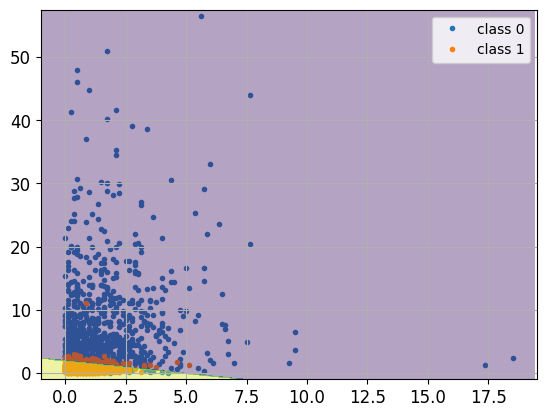

In [300]:
own_svm_y_pred = own_svm_predict(b_svm,w_svm,X_test)
print_accuracy_confusion(y_test, own_svm_y_pred, 'own_svm')

# A few lines to make own_svm_predict work with plot_feature_space_function (without implementing a fullblown sklearn calssifier)
import functools
own_svm_predict_param = functools.partial(own_svm_predict, b_svm, w_svm)

plot_feature_space_function(own_svm_predict_param, X_lin, y_binary_subset, axes, 0, 1)

**2.1.15)** Let's compare our solution to the one from sklearn.

w =  [[-0.42697222 -1.06654914]]
b =  [2.49401716]
lin_svm accuracy score: 0.8907216494845361
lin_svm confusion matrix:
 [[202  45]
 [  8 230]]


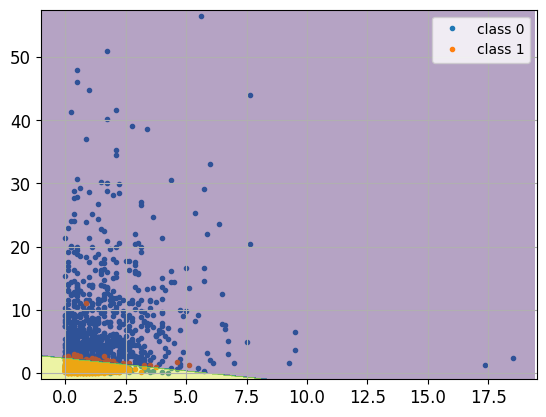

In [301]:
print('w = ',lin_svm_clf.coef_)
print('b = ',lin_svm_clf.intercept_)

print_accuracy_confusion(y_test, lin_svm_y_pred, 'lin_svm')
plot_feature_space_function(lin_svm_clf.predict, X_lin, y_binary_subset, axes, 0, 1)

Both the accuracy and the `w` parameter values should be close. Small differences occur depending on how the optimization is done (e.g., tolerances).

If you are interested in how this method is modified to build non-linear SVMs using the *kernel trick*, read pages **190-193**, 3rd edition, of the book.

Linear SVM implementation based on https://xavierbourretsicotte.github.io/SVM_implementation.html

## 2.2) Voting classifier

We already tried quite a few classifiers on this data set. Let's try to combine them in an ensemble (chapter 7 of the book).

First we'll define two more classifiers for the ensemble.

rf accuracy score: 0.8701030927835052
rf confusion matrix:
 [[210  37]
 [ 26 212]]


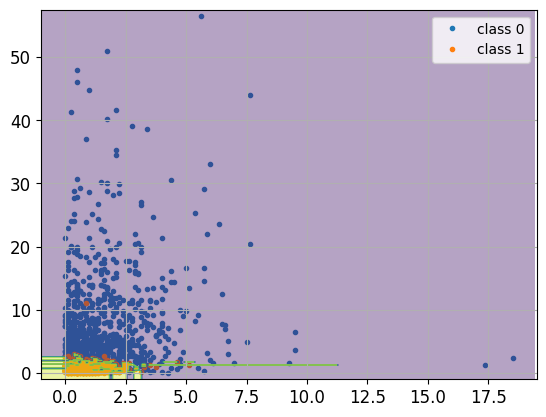

In [302]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)
print_accuracy_confusion(y_test, rf_y_pred, 'rf')
plot_feature_space_function(rf_clf.predict, X_lin, y_binary_subset, axes, 0, 1)

knn accuracy score: 0.8907216494845361
knn confusion matrix:
 [[209  38]
 [ 15 223]]


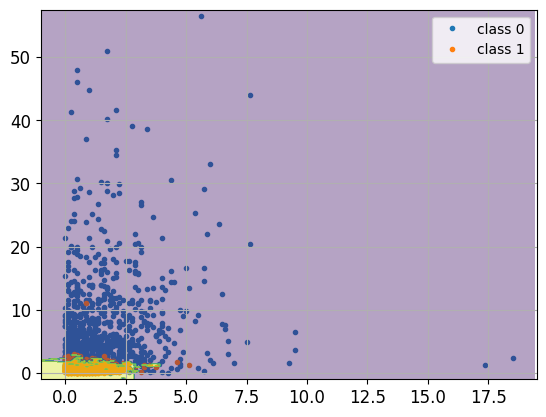

In [303]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(5)
knn_clf.fit(X_train, y_train)
knn_y_pred = knn_clf.predict(X_test)
print_accuracy_confusion(y_test, knn_y_pred, 'knn')
plot_feature_space_function(knn_clf.predict, X_lin, y_binary_subset, axes, 0, 1)

**2.2.01)** Combine (concatenate) the predictions of the SGD classifier `sgd_clf` (we implemented before looking into how to implement a linear SVM), the random forest `rf_clf`, and of the KNN `knn_clf` in one variable `combined_pred`.

In [304]:


# Collect predictions from each classifier
sgd_y_pred = sgd_clf.predict(X_test)
rf_y_pred = rf_clf.predict(X_test)
knn_y_pred = knn_clf.predict(X_test)

# Combine the predictions into one array
import numpy as np

# Stack the predictions vertically
combined_pred = np.vstack((sgd_y_pred, rf_y_pred, knn_y_pred))



In [305]:
assert combined_pred.shape[0] == 3
assert combined_pred.shape[1] == 485

**2.2.02)** Implement hard voting, i.e., generate a new variable `hard_voting_pred` where the prediction corresponds to that of the majority of the classifiers.

In [306]:
# **2.2.02)** Implement hard voting

from scipy.stats import mode

# Compute the mode along each row (axis=1)
hard_voting_pred, _ = mode(combined_pred, axis=1)

# Flatten the result to get a 1D array
hard_voting_pred = hard_voting_pred.flatten()

# Evaluate the performance
print_accuracy_confusion(y_test, hard_voting_pred, 'hard_voting')


ValueError: Found input variables with inconsistent numbers of samples: [485, 3]

In [235]:
assert hard_voting_pred.shape[0] == 485
assert hard_voting_pred.ndim == 1 or hard_voting_pred.shape[1] == 1
assert accuracy_score(y_test, hard_voting_pred) > 0.8927

**2.2.03)** Even this very simple voting approach brings the 3 classifiers that don't perform that well individually to the same level as your best performing classifier we had so far, the linear SVM.

#### 2.2.04) Bagging 
Now let's see what we can do with an ensemble of just our worst performing classifier, the SGD. The code is already provided below, your task is to adjust the parameters such that it beats the linear SVM by getting an accuracy >0.9

In [236]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

n_estimators=1
max_samples=1000
bootstrap=False



# Adjusting parameters
n_estimators = 100      # Increase the number of estimators
max_samples = 1.0       # Use all samples for each estimator
bootstrap = True        # Enable bootstrap sampling

# Create the BaggingClassifier with adjusted parameters
bag_clf = BaggingClassifier(
    base_estimator=SGDClassifier(random_state=0),
    n_estimators=n_estimators,
    max_samples=max_samples,
    bootstrap=bootstrap,
    random_state=0
)

# Fit the model
bag_clf.fit(X_train, y_train)

# Make predictions
bag_y_pred = bag_clf.predict(X_test)

# Evaluate the performance
print_accuracy_confusion(y_test, bag_y_pred, 'bag')


/Users/harshbhatia/Documents/RO47002/Practicums/env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


bag accuracy score: 0.9030927835051547
bag confusion matrix:
 [[216  31]
 [ 16 222]]


In [307]:
assert accuracy_score(y_test, bag_y_pred) > 0.9

### 3) Imitation Learning for Motion Planning

In the last section of this practicum, we will use our machine learning knowledge in a robotics example.

#### Motion Planning
Motion planning is a field of robotics in which robots have to plan and execute a trajectory in order to reach a goal. The following image shows the Mirte planning a path to reach its goal while avoiding obstacles.

<center><img src="img/Mirte.png" alt="drawing" width="400"/></center>

Commonly, these algorithms have to be designed and tuned by someone with knowledge in robotics and/or control. However, if we aim to have robots in our daily life outside industrial settings, such an approach becomes limiting, because it is not feasible to have a roboticist tuning every robot for every different situation.

#### Imitation Learning
Imitation Learning is a promising line of research that could address this problem. Imitation Learning can give humans, that are not experts in robotics/control, the ability to program a robot. The idea is simple, a human provides a set of demonstrations of a task, and a robot imitates her/him.

#### Goal

Build a Motion Planning algorithm that uses an Imitation Learning technique, called Behavioral Cloning, to fit a classifier, using Supervised Learning, to demonstrations provided by an *oracle*.

* **Oracle:** a system that provides demonstrations of a task. In our framing of the problem the oracle is a human. However, for practical reasons, in this assignment we are going to use a Motion Planning algorithm (Artificial Potential Fields, implementation from https://atsushisakai.github.io/PythonRobotics/modules/path_planning/grid_base_search/grid_base_search.html#potential-field-algorithm) as an oracle, and given that we are going to imitate its behavior, it is not required for you to know how this method works.

In [ ]:
from potential_field_planning import create_environment, potential_field_planning, classifier_planning, plot_environment
import numpy as np
import matplotlib.pyplot as plt

**3.01)** The function `create_environment` randomly generates a 2D environment that consists of a starting point `[sx, sy]`, a goal `[gx, gy]`, and obstacles `[ox, oy]`. The dimensionality of `ox` and `oy` is equal to the number of obstacles. 

Let's create an environment with one obstacle.

*Note: this function only supports 1, 2 or 3 obstacles.*

In [ ]:
env = create_environment(n_obstacles=1, seed=1)

print('Start              :', [env.sx, env.sy])
print('Goal               :', [env.gx, env.gy])
print('Obstacles x-coords  :', env.ox)
print('Obstacles y-coords  :', env.oy)
print('Number of obstacles:', len(env.ox))

**IMPORTANT:** do not modify the seed values.

The function `potential_field_planning` is the oracle. It takes as input the parameters of our environment and generates a collision-free path to the goal. The generated trajectory is saved in `trajectory`.

The function `plot_environment` can be used to visualize the environment, namely the obstacles (blue circles), start and goal position, and the trajectory.

**3.02)** Let's generate a trajectory with the oracle and visualize it:

In [ ]:
# Generate trajectory
trajectory = potential_field_planning(env)

# Show environment and trajectory
plot_environment(env, potential_field_trajectory=trajectory)

#### 3.03) Dataset

We can get trajectories from our oracle in multiple environments to build a dataset to train a classifier.


**Input:** In this context, the input of our machine learning model corresponds to the *robot's state* at a specific moment in time of the environment. Each one of these *moments* are known as time steps, and for every time step, as a function of the robot's state, our machine learning method has to make a decision on where to go next. 

**robot's state** = [gxd, gyd, oxd1,...,oxdn, oyd1, ..., oydn]

* **gxd**:  x distance from robot to goal
* **gyd**:  y distance from robot to goal
* **oxdi**: x distance from robot to obstacle i
* **oydi**: y distance from robot to obstacle i

**Output:** We are going to solve this problem as a classification problem. Each class corresponds to an *action* that the robot can take i.e., where to go next. These classes are represented using a vector that indicates the directions in which the robot can move.

**actions** = north, east, south, west, north-east, north-west, south-east, south-west. Represented with numbers from 0 to 7 respectively.

**3.03)** `trajectory` is a dictionary that contains the following information:
* `state`: the set of states visited by the robot. Each row of the state vector corresponds to the state of the robot in a specific time step. 
* `action`: the set of actions taken by the robot in every time step.
* `pos`: the positions that the robot visited, as visualized in the plot.
* `success`: a boolean indicating if the goal state was reached
* `collision`: a boolean indicating if the robot collided.

These names can be used as keys to access the data in the dictionary. 

Get the states and actions from `trajectory`.

In [ ]:
states = None
actions = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert np.abs(states[0, 1] + 4.66150302) < 1e-6
assert np.abs(states[4, 3] + 1.38529445) < 1e-6
assert np.abs(states[10, 2] + 1.68430939) < 1e-6
assert actions is not None


**3.04)** As mentioned before, the dimensionality of our state vector is a function of the number of obstacles in the environment. 

Build a function that computes the state dimensionality as a function of n obstacles:

*Note: this function has to be solved with an equation.*

In [ ]:
def get_state_dim(n_obstacles):
    state_dim = None
    # YOUR CODE HERE
    raise NotImplementedError()
    return state_dim

In [ ]:
assert get_state_dim(2) == 6
assert get_state_dim(4) == 10


**3.05)** Build a function called `generate_dataset` that repeats the following process n times:

    1) Create an environment.

    2) Get a demonstration from the oracle.

    3) Save demonstration, i.e., append visited states into an array called states and taken actions into an 
    array called actions.

The argument `ds_n_obstacles` indicates the number of obstacles the created environments will have, `n_trajectories` corresponds to the number of times the loop above will be repeated, and `show` is a boolean that makes the saved trajectories visible when true.

Wherever it says `MODIFY`, you should modify the code.

In [ ]:
def generate_dataset(ds_n_obstacles, n_trajectories, show=True):
    np.random.seed(18)  # reproducibility, do not change
    
    # Initialize our arrays
    states = np.empty([0, get_state_dim(ds_n_obstacles)])
    actions = np.empty([0])
    
    if show:
        # Create lists used for interactive animation
        envs = []
        trajectories = []
       
    for i in range(n_trajectories):            
        # Create environment
        ds_seed = np.random.randint(low=0, high=1e6)  # use this seed to create the environment
        env = None  # MODIFY
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Run planner and get a trajectory
        trajectory = None  # MODIFY
        # YOUR CODE HERE
        raise NotImplementedError()
        
        if show:
            # Store generated data for use in interactive animation
            envs.append(env)
            trajectories.append(trajectory)

        # Append data to arrays states and actions. 
        states = states # MODIFY, not None because it already exists
        actions = actions # MODIFY, not None because it already exists
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # Print progress
        if (i + 1) % (n_trajectories // 5 + 1e-6) == 0:
            print('Progress dataset: %d %%' % ((i + 1) / n_trajectories * 100))

    if show:
        # Generate an interactive ipython widget to visualize the generated environments and trajectories
        def plot_train_track(i):
            plot_environment(envs[i], potential_field_trajectory=trajectories[i])
            plt.title(f'dataset trajectory {i}')
        ipywidgets.interact(plot_train_track, i=(0,n_trajectories - 1))
    
    return states, actions

Create a dataset with 5 trajectories and 1 obstacle.

In [ ]:
states, actions = generate_dataset(ds_n_obstacles=1, n_trajectories=5, show=True)

In [ ]:
assert actions.shape == (77,)
assert states.shape == (77, 4)
assert np.abs(states[43, 3] - -0.142548887) < 1e-6
assert int(actions[60]) == 7


#### 3.06) Prepare data

After collecting a dataset, it is necessary to prepare the data for training.

**3.07)** In the collected dataset, the values `states[i, :]`, `states[i+1, :]` and `states[i+2, :]` are correlated (in most of the cases), because they are state transitions obtained in the same demonstration. This brakes an important machine learning assumption, which one? 

In [ ]:
# Uncomment the correct answer

#answer1 = 'the dataset is big and diverse enough, so our input space is properly represented'
#answer1 = 'the data has a linear relationship'
#answer1 = 'the data is i.i.d'
#answer1 = 'the kernel trick'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer1' in locals()


This problem is alleviated when we randomly sample from our dataset during training; however, we have to be careful to shuffle the dataset before splitting it into training and test; otherwise, the data in these sets will be highly correlated.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**3.08)** Using the above imported functions, build the function `data_preprocess`, which takes as an argument the `states` and `actions` arrays generated with `generate_dataset` function. The outputs must be scaled accordinig to fitted `standardScaler`.

In [ ]:
def data_preprocess(states, actions): 
    # Shuffle data with random_state=0
    shuffled_states, shuffled_actions = None, None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()

    # Separate data into train and test (20% of the data for test set with random_state=0)
    states_train, states_test, actions_train, actions_test = None, None, None, None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # Scale training and test data (remember that test data should never be used to fit data)
    states_train_scaled = None  # MODIFY
    states_test_scaled = None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()
    return states_train_scaled, states_test_scaled, actions_train, actions_test, scaler

In [ ]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/states_actions.npz')
# states = npzfile['states']
# actions= npzfile['actions']

**3.09)** Preprocess dataset

In [ ]:
states_train_scaled, states_test_scaled, actions_train, actions_test, scaler = data_preprocess(states, actions)

In [ ]:
assert states_train_scaled.shape == (61, 4)
assert states_test_scaled.shape == (16, 4)
assert actions_train.shape == (61,)
assert actions_test.shape ==(16,)
assert np.abs(states_train_scaled[10, 0] - 0.986126195) < 1e-6
assert np.abs(states_test_scaled[4, 3] + 0.129293968) < 1e-6
assert int(actions_train[43]) == 7
assert int(actions_test[3]) == 0


#### 3.10) Train classifier 
Build the function `train_classifier` that trains a classifier directly from `states` and `actions` and gets its accuracy score and confusion matrix.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def train_classifier(states, actions):
    # Prepare data
    states_train_scaled, states_test_scaled, actions_train, actions_test, scaler = None, None, None, None, None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # Train Random Forest with random_state=0
    clf = None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # Predict using test data
    actions_test_pred = None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()

    # Get accuracy score
    accuracy = None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()

    # Plot confusion matrix
    conf_matrix = None  # MODIFY
    # YOUR CODE HERE
    raise NotImplementedError()
    
    print(f'Accuracy: {accuracy:.3f}')
    print('\nConfusion matrix:\n\n', conf_matrix)
    
    return clf, accuracy, conf_matrix, scaler

In [ ]:
clf, accuracy, conf_matrix, scaler = train_classifier(states, actions)

In [ ]:
assert np.abs(accuracy - 0.9375) < 1e-6
assert conf_matrix.shape == (8, 8)
assert conf_matrix[3, 3] == 2

**3.11)** There's something about the obtained confusion matrix that indicates that the state/input space of the learning problem is, probably, not properly covered. What is it?

In [ ]:
# Uncomment the correct answer

#answer2a = 'it is not symmetrical'
#answer2a = 'it is sparse'
#answer2a = 'some rows/columns only have zeros'
#answer2a = 'it is not invertible'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer2a' in locals()


which implies that:

In [ ]:
# Uncomment the correct answer

#answer2b = 'many actions are not represented'
#answer2b = 'data is contradictory'
#answer2b = 'total number of data instances is too small'
#answer2b = 'training data is well balanced'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer2b' in locals()


### 3.12) Generate trajectories
The classifier got a high accuracy, but we observed that the input/state space is not properly covered, let's see how it performs as a planner. 

The following function generates trajectories from a trained classifier and returns its success rate. 

* A trajectory is considered to be successful if it reaches the goal before a time limit and does not collide with any obstacle.

* The `classifier_planning` function was imported at the beginning of the file and it creates a path using a classifier in a random environment. It returns a dictionary called `trajectory` (similar to `potential_field_planning`) but additionaly you can use the `success` and `collision` keys to check if the goal was reached.

* If `show=True`, the function will show the classifier's trajectories in purple and the Artificial Potential Field planner trajectories in red.

In [ ]:
def generate_trajectories_classifier(clf, scaler, ds_n_obstacles, n_trajectories_test, show=True):
    success_counter = 0  # count the number of times the robot reached the goal
    np.random.seed(50)  # reproducibility 

    if show:
        envs = []
        trajectories = []
    
    for i in range(n_trajectories_test):
        ds_seed = np.random.randint(low=0, high=1e6)
        
        # Create environment
        env = create_environment(n_obstacles=ds_n_obstacles, seed=ds_seed)
       
        # Generate trajectory
        trajectory = classifier_planning(env, clf, scaler)
        success = trajectory['success']
        
        if show:
            envs.append(env)
            trajectories.append(trajectory)

        # Count goal reached
        if success:
            success_counter += 1
            
        # Print if classifier fails
        if not success:
            print('Trial %i failed!' % i)
            
        # Print progress
        if (i + 1) % int(n_trajectories_test  / 5) == 0:
            print('Progress trials: %d %%' % ((i + 1) / n_trajectories_test * 100))
    
    success_rate = success_counter / n_trajectories_test
    print('\nSuccess rate: %.3f' % success_rate)
    
    if show:
        def plot_test_track(i):
            env = envs[i]
            success = trajectories[i]['success']
            collision = trajectories[i]['collision']

            pf_trajectory = potential_field_planning(env)
            plot_environment(env, potential_field_trajectory=pf_trajectory, classifier_trajectory=trajectories[i])
            plt.title(f'test trajectory {i}, success={success}, collision={collision}')
        ipywidgets.interact(plot_test_track, i=(0,n_trajectories_test-1))
    
    return success_rate

**3.13)** Carefully read this function and answer the questions.

**Q1:** What is the variable `n_trajectories_test`?

**Q2:** Why does the `classifier_planning` function needs the `scaler` in one of its inputs?

In [ ]:
# For each question uncomment on of the answers

# Answer Q1

#A1 = 'Number of environments to train the classifier'
#A1 = 'Number of environments to test the classifier'
#A1 = 'Number of environments in which the classifier was successful'
#A1 = 'Number of environments in which the classifier failed'

# YOUR CODE HERE
raise NotImplementedError()

# Answer Q2
#A2 = 'Because the environment has unscaled states, but the classifier expects scaled inputs'
#A2 = 'Because the environment has scaled states, but the classifier expects unscaled inputs'
#A2 = 'Because the classifier generates unscaled outputs, but the environment expects scaled actions'
#A2 = 'Because the classifier generates scaled outputs, but the environment expects unscaled actions'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'A1' in locals()
assert 'A2' in locals()


**3.14)** Run the function `generate_trajectories_classifier` to get the success rate of the learned planner over **100 environments** with **one obstacle** and save it in the variable `suc_5t`.

In [ ]:
#if you are stuck here, uncomment the lines below to load variables

# In this case it is required to have pickle installed in the homl3 environment: pip install pickle-mixin

# import pickle 
# with open('./get_unstuck/clf_fitted', 'rb') as config_dictionary_file:
#    config_dictionary = pickle.load(config_dictionary_file) 
    
# clf = config_dictionary['clf']
# scaler = config_dictionary['scaler']

In [ ]:
suc_5t = None  # MODIFY
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Please note: The expected outcome for the classifier should be better than 40%.
assert suc_5t > 0.4


**3.15)** The success rate of the classifier is low, which indicates that the learned planner will fail to reach of the goal more than half of the times. Taking into consideration **3.10**, what should we try to increase the performance of our planner?

In [ ]:
# Uncomment the correct answer

#answer3 = 'a different learning algorithm'
#answer3 = 'feature engineering'
#answer3 = 'filter outliers'
#answer3 = 'increase the size of the dataset'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer3' in locals()


#### 3.16) Repeat experiment with different settings
Using the functions the we created so far in this section, a new function can be constructed to run the complete experiment with different settings using as arguments `ds_n_obstacles`, `n_trajectories_dataset` and `n_trajectories_test`.

In [ ]:
def run_experiment(ds_n_obstacles, n_trajectories_dataset, n_trajectories_test, show=True):
    # Create database
    print('1) Create dataset: \n')
    states, actions = generate_dataset(ds_n_obstacles, n_trajectories_dataset, show=show)

    # Train classifier
    print('\n2) Train classifier: \n')
    clf, accuracy, conf_matrix, scaler = train_classifier(states, actions)

    # Generate trajectories with classifier
    print('\n3) Test classifier: \n')
    success_rate = generate_trajectories_classifier(clf, scaler, ds_n_obstacles, n_trajectories_test, show=show)
    return success_rate

**3.17)** Let's repeat the experiment with 20 trajectories in the dataset.

In [ ]:
run_experiment(ds_n_obstacles=1, n_trajectories_dataset=20, n_trajectories_test=100, show=True)

**3.18)** The new planner B got an accuracy of 0.919 and a success rate of 0.97. The previous planner A got an accuracy of 0.938 and a success rate of 0.45. What can you conclude?

In [ ]:
# Uncomment the correct answer

#answer4 = 'A is slightly better because its accuracy is higher, but its success rate is lower'
#answer4 = 'B is slightly better because its success rate is higher, but its accuracy is lower'
#answer4 = 'A is clearly better because the accuracy better represents the performance of the planner'
#answer4 = 'B is clearly better because the success rate better represents the performance of the planner'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer4' in locals()


**3.19)** Therefore, can we conclude that increasing the size of the dataset helped to improve the performance of the learned planner? Choose the best answer.

In [ ]:
# Uncomment the correct answer

#answer5 = 'yes, slightly'
#answer5 = 'yes, a lot'
#answer5 = 'it is not clear'
#answer5 = 'no, it decreased'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer5' in locals()


#### 3.20) Multiple Obstacles
So far, we have been using environments with one obstacle, let's see what happens if we use environments with two obstacles.

In [ ]:
run_experiment(ds_n_obstacles=2, n_trajectories_dataset=20, n_trajectories_test=100, show=True)

**3.21)** The success rate decreased to 0.79 :(. What could be the most important reason? (*Hint:* this is an appetizer of chapter 8 in the book)

In [ ]:
# Uncomment the correct answer

#answer6 = 'there are many random variables that can influence the performance, so it is probably unluckiness'
#answer6 = 'the curse of dimensionality'
#answer6 = 'it is easier to collide if there are two obstacles'
#answer6 = 'the problem became nonlinear'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert 'answer6' in locals()


**3.22)** Once again, this problem can be alleviated with more data. Let's retrain using 100 trajectories.

In [ ]:
run_experiment(ds_n_obstacles=2, n_trajectories_dataset=100, n_trajectories_test=100, show=True)

We can observe that the success rate increased to 0.89, which is not as good as before, but still is a good improvement :).

#### 3.23) Repeat experiments with different settings and compare
To finalize this assignment, we have the function `repeat_experiments` that gets the success rate of the classifier when trained with datasets of different sizes and different number of obstacles.

In [ ]:
def repeat_experiments(n_trajectories_list, n_obstacles_list):  
    success_rate_list_obstacle = []
    
    # Iterate for every obstacle number
    for i in n_obstacles_list:
        print('\nNumber of obstacles:', i)
        success_rate_list_n_trajectories = []
        
        # Iterate for every number of trajectories in dataset
        for j in n_trajectories_list:
            print('\nNumber trajectories dataset:', j)
            
            # Get success rate
            suc_it = run_experiment(ds_n_obstacles=i, n_trajectories_dataset=j, n_trajectories_test=100, show=False)
            success_rate_list_n_trajectories.append(suc_it)
            
        success_rate_list_obstacle.append(success_rate_list_n_trajectories)      
    return success_rate_list_obstacle

**3.24)** Run it for 1, 2, and 3 obstacles, and for 1, 10, 20, 40, 60 and 80 demonstrations in our dataset.

*Warning: it will take some time to get these results. It's a good opportunity to get a nice cup of tea...*

In [ ]:
n_trajectories_list = [1, 10, 20, 40, 60, 80, 100]
n_obstacles_list = [1, 2, 3]
success_rate_list = repeat_experiments(n_trajectories_list, n_obstacles_list=n_obstacles_list)

**3.25)** Let's plot these results!

In [ ]:
# Empty space for debugging your code if you are stuck. DO NOT REMOVE even if you don't end up using this space.



In [ ]:
#if you are stuck here, uncomment the lines below to load variables
# npzfile = np.load('./get_unstuck/plot1.npz')
# success_rate_list= npzfile['success_rate_list']

In [ ]:
n_trajectories_list = [1, 10, 20, 40, 60, 80, 100]
n_obstacles_list = [1, 2, 3]

for i in range(len(n_obstacles_list)):
    plt.plot(n_trajectories_list, success_rate_list[i], linestyle='--', linewidth=2, label=('%i obstacle(s)' % (i+1)))
    plt.scatter(n_trajectories_list, success_rate_list[i], linewidth=3)
    
plt.grid('on')
plt.xlabel('Number of trajectories in dataset')
plt.ylabel('Success rate')
plt.title('Influence of dataset size in success rate')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()
plt.show()

**3.26)** We can observe that increasing the dataset size will increase the performance of the classifier in environments with 1, 2, and 3 obstacles. This performance, however, seems to be bounded (and this bound gets lower as the number of obstacles increases), which suggests that adding more data will not be enough to completely solve this problem. Why do you think this is the case?

Answer

**3.27)** In the motivation of this problem, we mentioned that Imitation Learning can be used to learn from humans. However, from this plot, we can observe that as the problem gets more complex (more obstacles in this case), more data is required to find good solutions. More data means more human time to generate the demonstrations, and human time is expensive.

What limitations do you see in the approach that we used in this assignment to solve the motion planning problem?

Answer

That's it! Congratulations for reaching the end of this practicum :)